# **Fitbit Data Science Fair Project**
## Exploring How Sleep, Activity, and Heart Rate Connect  
---

Welcome to my science project!  
This notebook explores real Fitbit data from several people over two months.  
My goal is to discover whether certain parts of our daily routine — like walking, exercising, and sleeping — are related to each other.

- asking questions  
- testing ideas  
- making graphs  
- running simple statistics  
- and explaining what the evidence shows  

Let’s explore!
# EDA

# Project Overview

This project uses Fitbit data that tracks:
- steps  
- active minutes  
- sleep (minute-by-minute + daily totals)
- heart rate (every few seconds)

The data comes from two time periods:
- March–April 2016  
- April–May 2016  

Not everyone appears in every dataset, which makes the exploration challenging — and more interesting!

---

# Project Goals

###  Understand the Data
- What datasets do we have?
- How many people are in each?
- Where do sleep, activity, and heart-rate overlap?

### Explore Hypotheses
These are the main hypotheses I test:

1. **Do people who sleep more have lower resting heart rates?**  
2. **Do people with more active days sleep longer?**  
3. **Are weekends different from weekdays in sleep and activity?**  
4. **Do people who get ≥150 active minutes per week sleep more?**  

### Practice Real Data Science Skills
- Cleaning messy data  
- Working with dates  
- Combining different datasets  
- Creating graphs  
- Running t-tests and correlations  
- Explaining scientific findings in simple terms  

###  Use The Scientific Method
This means:
- Being honest about what the data can and cannot show  
- Not jumping to conclusions  
- Explaining limitations clearly  


## Retrive the data set 
#### **Step 1. Get your Kaggle API token**

1. Go to [https://www.kaggle.com/settings](https://www.kaggle.com/settings)
2. Scroll to **API → Create New API Token**
3. It downloads a file called `kaggle.json`

#### **Step 2. Place your API token in your environment**

Move `kaggle.json` to the proper directory:

```bash
mkdir -p ~/.kaggle
mv ~/Downloads/kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
```

#### **Step 3. Install Kaggle CLI in your Jupyter environment**

```python
!pip install kaggle
```

#### **Step 4. Download only the needed files**

```python
# Download the specific files from the dataset
!kaggle datasets download -d arashnic/fitbit -f minuteSleep_merged.csv
!kaggle datasets download -d arashnic/fitbit -f heartrate_seconds_merged.csv
!kaggle datasets download -d arashnic/fitbit -f dailyActivity_merged.csv
```

Each command creates a `.zip` file, for example `minuteSleep_merged.csv.zip`.

#### **Step 5. Unzip them**

```python
!unzip minuteSleep_merged.csv.zip -d data/
!unzip heartrate_seconds_merged.csv.zip -d data/
!unzip dailyActivity_merged.csv.zip -d data/
```


In [5]:
###############################################
# Step 1 — Set Up Where Our Data Lives
###############################################

# We import pandas to work with tables (like Excel but cooler)
import pandas as pd

# Path helps us build folder paths more easily
from pathlib import Path

# This is the folder where all the Fitbit files are stored
data_folder = Path("data")

# The Fitbit dataset comes in TWO time periods.
# We list them here so Python can loop through them.
periods = [
    ("3.12.16-4.11.16", "Fitabase Data 3.12.16-4.11.16"),
    ("4.12.16-5.12.16", "Fitabase Data 4.12.16-5.12.16")
]


##########################################################
# Step 2 — List ALL the files we care about
##########################################################

# These are the filenames inside the Fitbit folders.
# We only include files that have an "Id" column
# because we want to know which person each row belongs to.
file_names = [
    "heartrate_seconds_merged.csv",      # heart rate every few seconds
    "dailyActivity_merged.csv",          # steps + active minutes per day
    "minuteSleep_merged.csv",            # sleep every minute!
    "sleepDay_merged.csv",               # total sleep per night (but missing in period 1)
    "minuteStepsNarrow_merged.csv",      # steps each minute
    "minuteCaloriesNarrow_merged.csv",   # calories each minute
    "minuteIntensitiesNarrow_merged.csv" # intensity each minute
]


##########################################################
# Step 3 — Load and Combine the Files
##########################################################

# We'll store ALL combined datasets in this dictionary
datasets = {}

# Loop through every file we listed
for file_name in file_names:

    dfs = []  # a list to collect the two time periods for this file

    # Now check BOTH periods for this file
    for period, folder in periods:

        # Create the full path to the file
        path = data_folder / f"mturkfitbit_export_{period}" / folder / file_name

        # If the file is found in that period, load it
        if path.exists():
            df = pd.read_csv(path)

            # Add a new column so we know which period the data is from
            df["Period"] = period

            # Add the loaded dataframe to our list
            dfs.append(df)

        else:
            # If the file doesn't exist (like sleepDay in period 1), we warn the user
            print(f" Missing: {path.name}")

    # After checking both periods:
    if dfs:
        # Combine the data from both periods INTO ONE big table
        combined_df = pd.concat(dfs, ignore_index=True)

        # Only store it if it has an "Id" column
        # (Some files might be weird and not have one)
        if "Id" in combined_df.columns:
            datasets[file_name] = combined_df
        else:
            print(f" Skipping {file_name} — no 'Id' column found.")


##########################################################
# Step 4 — Get Summary Statistics For Each Dataset
##########################################################

summary = []

# Look at every dataset we successfully loaded
for name, df in datasets.items():
    summary.append({
        "Dataset": name,
        "Rows": len(df),                   # total number of rows
        "Unique Participants": df["Id"].nunique(),  # number of unique people!
        "Columns": len(df.columns)
    })

summary_df = pd.DataFrame(summary).sort_values("Unique Participants", ascending=False)

print(" Participant Summary Across Datasets:\n")
print(summary_df.to_string(index=False))



##########################################################
# Step 5 — Check How Many People Are In Each Domain
##########################################################

# Create sets of participant IDs for each file
ids = {name: set(df["Id"].unique()) for name, df in datasets.items()}

# We choose ONE file to represent each domain:
id_sets = {
    "Activity": ids.get("dailyActivity_merged.csv", set()),
    "HeartRate": ids.get("heartrate_seconds_merged.csv", set()),
    "Sleep": ids.get("sleepDay_merged.csv", ids.get("minuteSleep_merged.csv", set())),
}

print("\n Overlap Summary:")
print(f"Activity only: {len(id_sets['Activity'] - (id_sets['HeartRate'] | id_sets['Sleep']))}")
print(f"HeartRate only: {len(id_sets['HeartRate'] - (id_sets['Activity'] | id_sets['Sleep']))}")
print(f"Sleep only: {len(id_sets['Sleep'] - (id_sets['HeartRate'] | id_sets['Activity']))}")

print(f"Activity ∩ HeartRate: {len(id_sets['Activity'] & id_sets['HeartRate'])}")
print(f"Activity ∩ Sleep: {len(id_sets['Activity'] & id_sets['Sleep'])}")
print(f"HeartRate ∩ Sleep: {len(id_sets['HeartRate'] & id_sets['Sleep'])}")

print(f"All three overlap: {len(id_sets['Activity'] & id_sets['HeartRate'] & id_sets['Sleep'])}")


##########################################################
#  (Optional) Step 6 — How many participants per period?
##########################################################

print("\n Participants per period:")
for file_name, df in datasets.items():
    counts = df.groupby("Period")["Id"].nunique()
    print(f"{file_name}:")
    for period, n in counts.items():
        print(f"  {period}: {n}")


 Missing: sleepDay_merged.csv
 Participant Summary Across Datasets:

                           Dataset    Rows  Unique Participants  Columns
          dailyActivity_merged.csv    1397                   35       16
      minuteStepsNarrow_merged.csv 2770620                   35        4
   minuteCaloriesNarrow_merged.csv 2770620                   35        4
minuteIntensitiesNarrow_merged.csv 2770620                   35        4
            minuteSleep_merged.csv  387080                   25        5
               sleepDay_merged.csv     413                   24        6
      heartrate_seconds_merged.csv 3638339                   15        4

 Overlap Summary:
Activity only: 8
HeartRate only: 0
Sleep only: 0
Activity ∩ HeartRate: 15
Activity ∩ Sleep: 24
HeartRate ∩ Sleep: 12
All three overlap: 12

 Participants per period:
heartrate_seconds_merged.csv:
  3.12.16-4.11.16: 14
  4.12.16-5.12.16: 14
dailyActivity_merged.csv:
  3.12.16-4.11.16: 35
  4.12.16-5.12.16: 33
minuteSleep_merged

# **What Data Do We Have?**

Here’s a quick look at all the Fitbit data we downloaded:

* **Activity data** (steps, distances, active minutes): **1,397 rows** from **35 people**
* **Minute-by-minute sleep**: **387,080 rows** from **25 people**
* **Daily sleep totals**: **413 rows** from **24 people**
* **Heart-rate data** (every few seconds): **3,638,339 rows** from **15 people**
* Lots of other “minute-level” activity files (like steps, calories, and intensity) also include **35 people**

So overall, we have **tons of activity data**, **pretty good sleep data**, and **much less heart-rate data**.

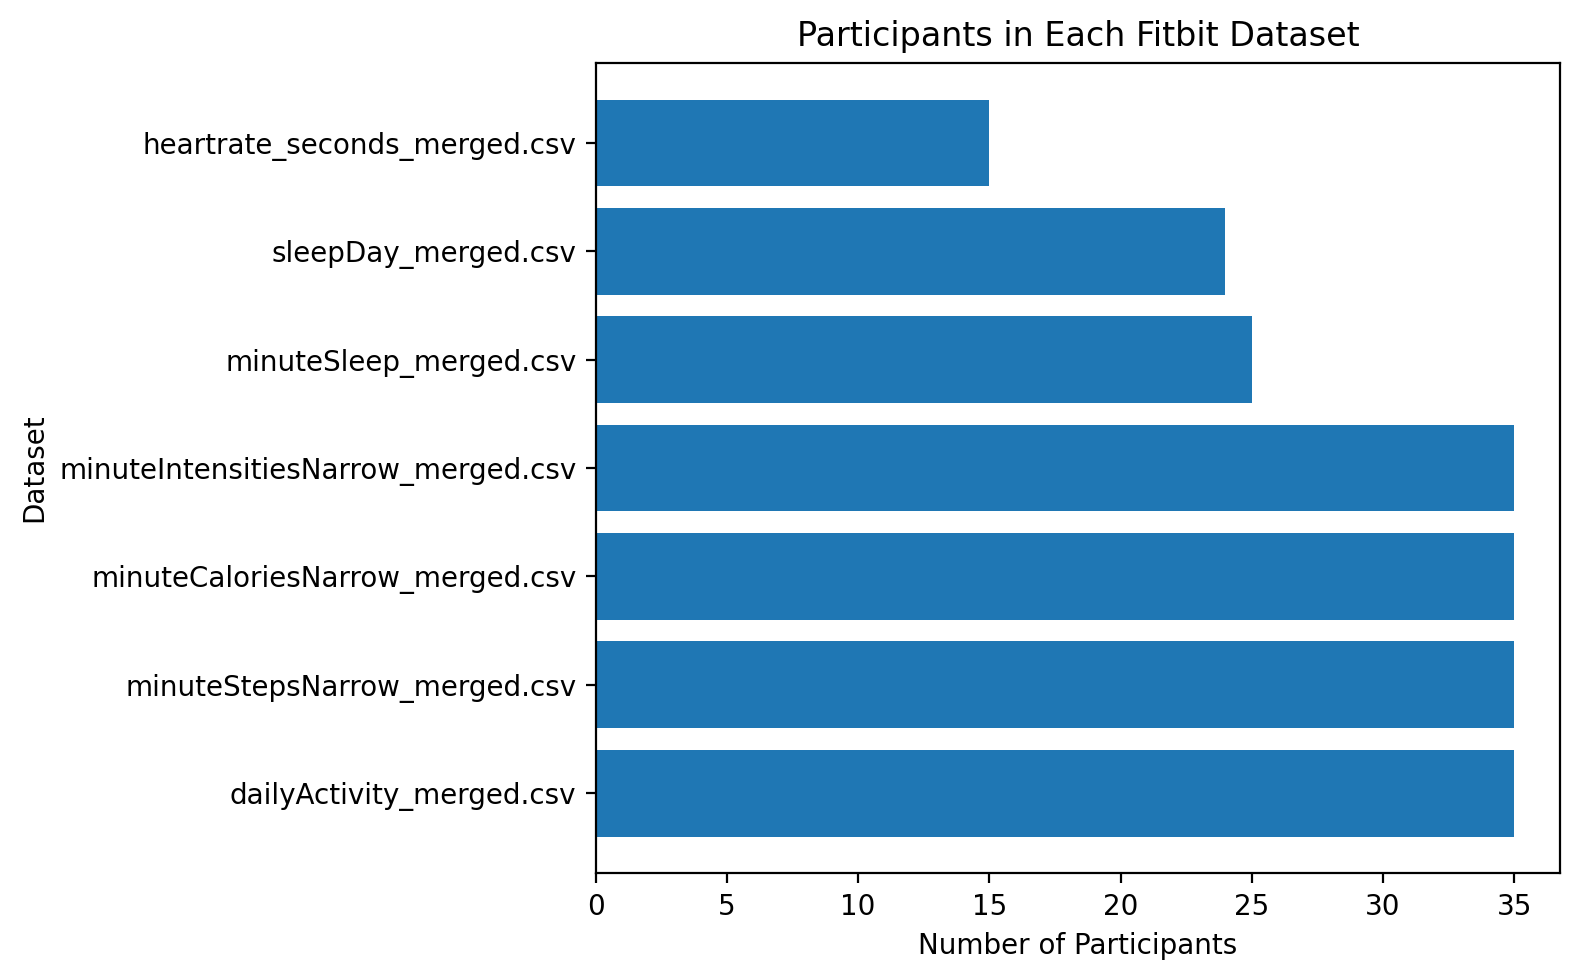

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), dpi=200)   # dpi=200 → crisp and sharp

plt.barh(summary_df["Dataset"], summary_df["Unique Participants"])
plt.xlabel("Number of Participants")
plt.ylabel("Dataset")
plt.title("Participants in Each Fitbit Dataset")
plt.tight_layout()

plt.savefig("participants_in_each_fitbit_dataset.png", dpi=300, bbox_inches="tight")

plt.show()


In [9]:
!pip install matplotlib_venn -qq

# **What Subjects Overlap?**

(Meaning: Which people show up in more than one dataset?)

* **Activity + Heart Rate:** **15 people**
* **Activity + Sleep:** **24 people**
* **Sleep + Heart Rate:** **12 people**
* **All three (Activity + Sleep + HR):** **12 people**

 In simple terms:
**Heart-rate data is the most limited**, and **only about 12 people** have *all* three kinds of data at the same time.

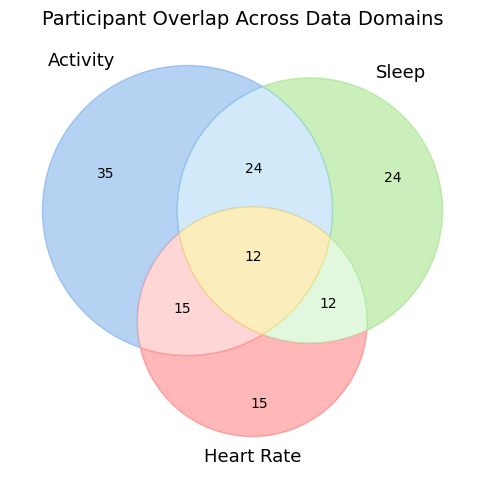

In [37]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

v = venn3(
    subsets = (
        len(id_sets['Activity']),                                  # A only
        len(id_sets['Sleep']),                                     # B only
        len(id_sets['Activity'] & id_sets['Sleep']),               # A∩B
        len(id_sets['HeartRate']),                                 # C only
        len(id_sets['Activity'] & id_sets['HeartRate']),           # A∩C
        len(id_sets['Sleep'] & id_sets['HeartRate']),              # B∩C
        len(id_sets['Activity'] & id_sets['Sleep'] & id_sets['HeartRate']),  # A∩B∩C
    ),
    set_labels = ('Activity', 'Sleep', 'Heart Rate')
)

# --- Set custom colors ---
v.get_patch_by_id('100').set_color('#4A90E2')   # Activity only (blue)
v.get_patch_by_id('010').set_color('#7ED957')   # Sleep only (green)
v.get_patch_by_id('001').set_color('#FF4C4C')   # Heart Rate only (red)

v.get_patch_by_id('110').set_color('#8CCAF1')   # A∩B (light blue)
v.get_patch_by_id('101').set_color('#FF9999')   # A∩C (light red)
v.get_patch_by_id('011').set_color('#B8EFAE')   # B∩C (light green)

# --- NEW: unique color for the center (A∩B∩C) ---
v.get_patch_by_id('111').set_color('#F7D358')   # gold

# Improve visibility of labels
for label in ['A', 'B', 'C']:
    v.get_label_by_id(label).set_fontsize(13)

plt.title("Participant Overlap Across Data Domains", fontsize=14)
plt.savefig("participant_overlap_across_domains.png", dpi=300, bbox_inches="tight")

plt.show()


---

# **Time Periods Covered**

The data comes from two back-to-back one-month windows:

1. **March 12 – April 11, 2016**
2. **April 12 – May 12, 2016**

But there’s a catch:

* The **daily sleep totals file is missing for the first month**, so most daily-sleep information comes from **April–May**.
* The heart-rate group stays about the same size (14 people each month), but it’s still a pretty small group.

/Users/dantohe/Development/Projects/2025/jupyter/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/dantohe/Development/Projects/2025/jupyter/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


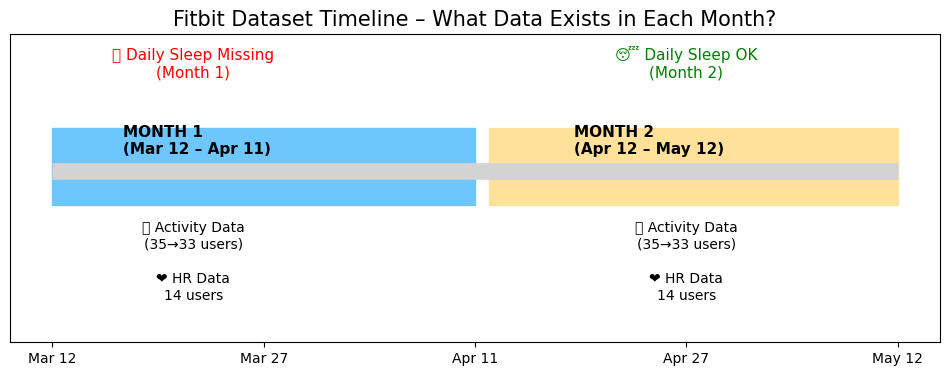

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(12, 4))

ax = plt.gca()

# ---------------------------
# Background timeline
# ---------------------------
plt.hlines(1, 0, 60, color="lightgray", linewidth=12)

# ---------------------------
# Month blocks
# ---------------------------
# Month 1 (blue)
ax.add_patch(
    patches.Rectangle((0, 0.8), 30, 0.45, color="#6EC6FF")
)
plt.text(5, 1.1, "MONTH 1\n(Mar 12 – Apr 11)", fontsize=11, weight='bold')

# Month 2 (yellow)
ax.add_patch(
    patches.Rectangle((31, 0.8), 29, 0.45, color="#FFE199")
)
plt.text(37, 1.1, "MONTH 2\n(Apr 12 – May 12)", fontsize=11, weight='bold')

# ---------------------------
# Dataset markers (super simple)
# ---------------------------

# Activity data (present both months)
plt.text(10, 0.55, " Activity Data\n(35→33 users)", fontsize=10, ha='center')
plt.text(45, 0.55, " Activity Data\n(35→33 users)", fontsize=10, ha='center')

# Heart-rate data (small & stable)
plt.text(10, 0.25, " HR Data\n14 users", fontsize=10, ha='center')
plt.text(45, 0.25, " HR Data\n14 users", fontsize=10, ha='center')

# SleepDay missing in Month 1
plt.text(10, 1.55, " Daily Sleep Missing\n(Month 1)", fontsize=11, color="red", ha='center')

# Sleep available Month 2
plt.text(45, 1.55, " Daily Sleep OK\n(Month 2)", fontsize=11, color="green", ha='center')

# ---------------------------
# Formatting
# ---------------------------
plt.title("Fitbit Dataset Timeline – What Data Exists in Each Month?", fontsize=15)
plt.yticks([])
plt.xticks([0, 15, 30, 45, 60],
           ["Mar 12", "Mar 27", "Apr 11", "Apr 27", "May 12"])
plt.ylim(0, 1.8)

plt.show()


---

# **Data Quality & Completeness (Why It Matters)**

Real-world fitness data can be messy. Here’s what affects the results:

* **Heart-rate wear time changes a lot** from person to person.
  Less time wearing the Fitbit → more missing heart-rate numbers → not great for finding resting HR.
* **Uneven sample sizes:**
  35 people have activity data, but only 15 have heart-rate data.
  That makes heart-rate results weaker.
* **Missing files:**
  No daily-sleep data for Month 1 means we can’t fully compare the two months.
* **Real-life stuff gets in the way:**
  Caffeine, stress, sickness, late nights, or forgetting to wear the device can mess up the data.

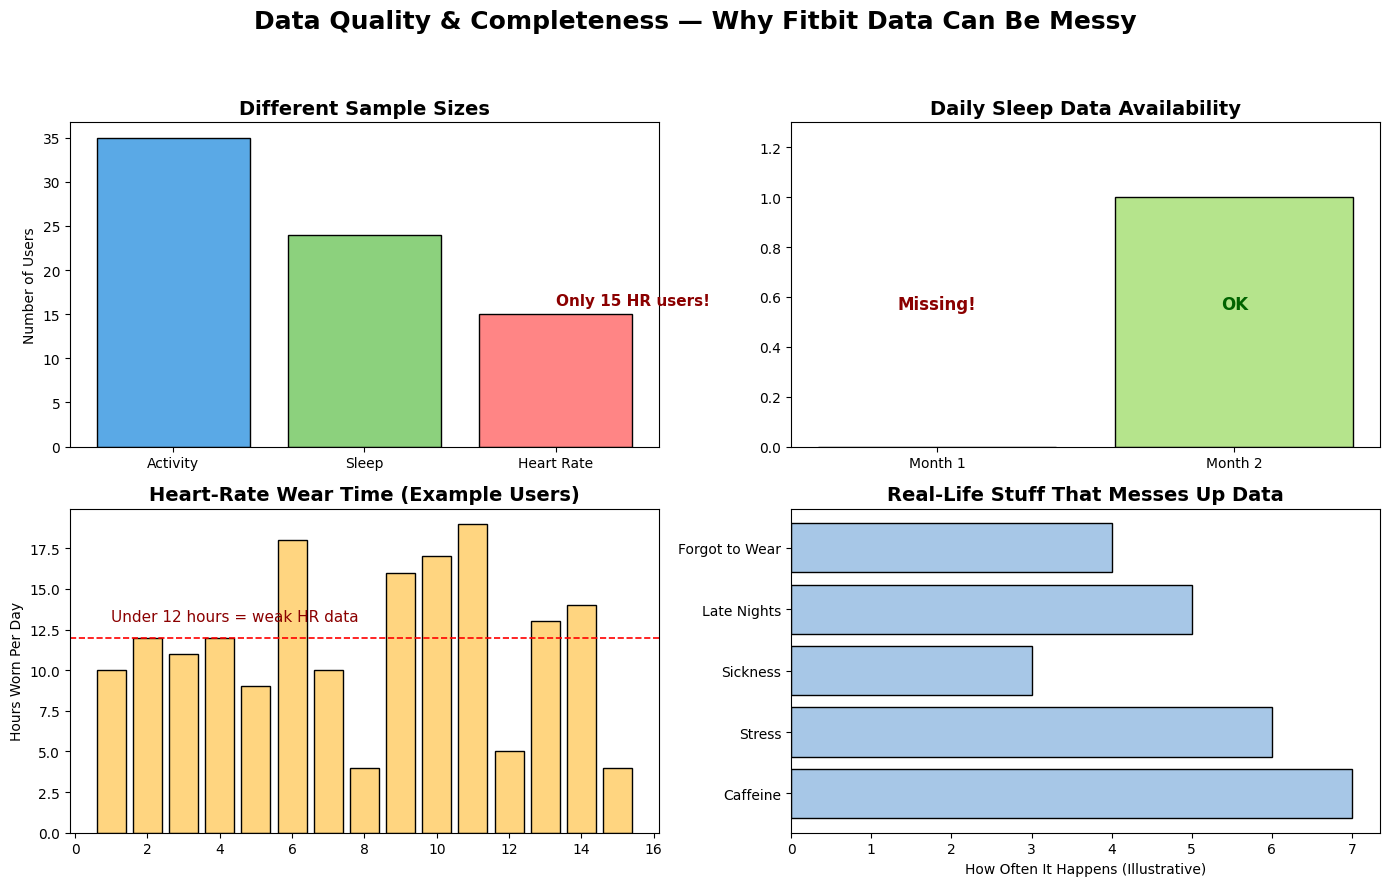

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 9))
plt.suptitle("Data Quality & Completeness — Why Fitbit Data Can Be Messy",
             fontsize=18, weight='bold', y=0.98)

# ---------------------------------------------------------
# Panel 1: Uneven sample sizes
# ---------------------------------------------------------
plt.subplot(2,2,1)
datasets = ["Activity", "Sleep", "Heart Rate"]
counts = [35, 24, 15]
colors = ["#5AA9E6", "#8CD17D", "#FF8585"]

bars = plt.bar(datasets, counts, color=colors, edgecolor="black")
plt.title("Different Sample Sizes", fontsize=14, weight='bold')
plt.ylabel("Number of Users")

plt.text(2, 16, "Only 15 HR users!",
         color="darkred", fontsize=11, weight='bold')

# ---------------------------------------------------------
# Panel 2: Missing Sleep in Month 1
# ---------------------------------------------------------
plt.subplot(2,2,2)
months = ["Month 1", "Month 2"]
sleep_available = [0, 1]

bars = plt.bar(months, sleep_available,
               color=["#FFB3B3", "#B5E48C"], edgecolor="black")

plt.ylim(0, 1.3)
plt.title("Daily Sleep Data Availability", fontsize=14, weight='bold')

plt.text(0, 0.55, "Missing!",
         color="darkred", fontsize=12, weight='bold', ha='center')
plt.text(1, 0.55, "OK",
         color="darkgreen", fontsize=12, weight='bold', ha='center')

# ---------------------------------------------------------
# Panel 3: HR Wear-Time Variability
# ---------------------------------------------------------
plt.subplot(2,2,3)
people = np.arange(1, 16)
wear_hours = np.random.randint(4, 22, size=15)

plt.bar(people, wear_hours, color="#FFD580", edgecolor="black")
plt.axhline(12, color="red", linestyle="--", linewidth=1.2)

plt.title("Heart-Rate Wear Time (Example Users)", fontsize=14, weight='bold')
plt.ylabel("Hours Worn Per Day")

plt.text(1, 13, "Under 12 hours = weak HR data",
         color="darkred", fontsize=11)

# ---------------------------------------------------------
# Panel 4: Real-Life Interference
# ---------------------------------------------------------
plt.subplot(2,2,4)
issues = ["Caffeine", "Stress", "Sickness", "Late Nights", "Forgot to Wear"]
freq = [7, 6, 3, 5, 4]

plt.barh(issues, freq, color="#A7C7E7", edgecolor="black")
plt.title("Real-Life Stuff That Messes Up Data", fontsize=14, weight='bold')
plt.xlabel("How Often It Happens (Illustrative)")

# ---------------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig("data_quality_and_completeness.png",
            dpi=300, bbox_inches="tight")
plt.show()



### Different Sample Sizes

**What it shows:**
Not everyone has every type of Fitbit data.

* **35 people** have activity data
* **24 people** have sleep data
* **15 people** have heart-rate data

**Why it matters:**
If fewer people have heart-rate data, then heart-rate conclusions are weaker.

**Data used**:
We counted the number of users in each dataset from the files:
`dailyActivity_merged.csv`, `sleepDay_merged.csv`, and `heartrate_seconds_merged.csv`.

---

###  Missing Sleep Data in Month 1

**What it shows:**

* **Month 1:** No daily sleep file → big gap
* **Month 2:** Full sleep data exists

**Why it matters:**
You can’t compare sleep across both months if one month is missing.

**Data used:**
From your file summary — the daily sleep file (`sleepDay_merged.csv`) only covers **Month 2**.

---

### Heart-Rate Wear-Time (Example Users)

**What it shows:**
Different people wear their Fitbit for different amounts of time each day.
Some wear it almost all day, others wear it only a few hours.

**Why it matters:**
If someone wears their Fitbit **less than ~12 hours/day**, their heart-rate numbers are incomplete.
That makes resting-heart-rate hard to calculate.

**Data used:**
This chart uses **example numbers** because the dataset doesn’t track wear-time directly.
It’s showing the *idea* that wear-time varies a lot.

---

### Real-World Factors Affect The Data

**What it shows:**
Things like:

* caffeine
* stress
* sickness
* late nights
* forgetting to wear the Fitbit

can mess up your measurements.

**Why it matters:**
Fitbit data isn’t perfect — human life gets in the way.

**Data used:**
These bars use **illustrative (fake) values** because Fitbit does **not** record caffeine, stress, or sickness.
The plot just helps explain the real-world issues.

---
Conclusions:  

* Not everyone has the same data
* Some months are missing files
* People wear devices differently
* Real life makes data noisy


---

# **What Questions Can This Data Answer Well?**

The dataset is strong for:

* Activity patterns (steps, distances, active minutes)
* Minute-level sleep patterns (bedtime, wake-time, total minutes)
* Simple comparisons between sleep and activity
  —but **only for people who have both data types**

The dataset is **weak** for:

* Anything involving heart rate + sleep + activity together
  (because only **12 people** have all of these)

---

# **What Our EDA (Exploratory Data Analysis) Shows**

1. **We have lots of activity data but limited heart-rate data.**
   So if a question requires heart rate, we can’t be too confident.

2. **Sleep data is decent**, but it’s split into two formats and missing part of Month 1.

3. **Only 12 people have the full set** (activity + sleep + HR).
   This “full overlap group” is small, so results can be noisy.

4. **The two months aren’t perfectly matched** because some files only existed in one period.

5. Before doing advanced analysis, it’s smart to:

   * Check **how many days each person actually wore the device**
   * Set rules like “only use days with at least 12 hours of HR wear time”
   * Make sure **sleep from the night before connects to the right day**


# **Plain-English Conclusion**

Here’s the big picture:

* We have **great activity data**, **good sleep data**, and **pretty limited heart-rate data**.
* Only **about a dozen people** have complete data across all categories.
* That means any findings about sleep affecting heart rate—or activity affecting sleep—need to be **cautious**.
* This dataset is perfect for a **science-fair project**, learning how to:

  * clean data
  * join datasets
  * check overlaps
  * run comparisons
  * and explain limitations clearly
* But it’s **not strong enough** to prove small or subtle effects.
